# DKL Nonlinearity Work
June, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)

*   DKL realized by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en) in [AtomAi](https://atomai.readthedocs.io/en/latest/) 

*   Analysis and implementation by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

*   PTO sample provided by Prof. Hiroshi Funakubo


Imports:

In [1]:
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git
!pip install pycroscopy;
!pip install torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 gpytorch==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-ro_2_tnd
  Running command git clone -q https://github.com/ziatdinovmax/atomai.git /tmp/pip-req-build-ro_2_tnd
     |████████████████████████████████| 193 kB 7.2 MB/s 
     |████████████████████████████████| 353 kB 47.7 MB/s 
     |████████████████████████████████| 865 kB 37.2 MB/s 
  Created wheel for atomai: filename=atomai-0.7.2-py3-none-any.whl size=146750 sha256=ab98cdc3e4f68a7b5b84ae25c94bd9c123c4a6d3ba2b0950df7ef67a0c4b47cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-4alkfvxq/wheels/09/e2/93/9ef2ffaa14a8a470a9865df84bee8456134d80714b0b30e5e5
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=91e798e3700ba886320c7de30d733c0452a55e0a4f43ba18345861ebd3cf9e58
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.5 kB/s 
     |████████████████████████████████| 17.4 MB 34.6 MB/s 
     |████████████████████████████████| 7.1 MB 30.2 MB/s 
     |████████████████████████████████| 498 kB 61.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.7.0
    Uninstalling gpytorch-1.7.0:
      Successfully unins

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

import atomai as aoi

import torch
import gpytorch

from atomai import utils
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

Download training data:

Load data:

In [3]:
!gdown https://drive.google.com/uc?id=10cYk2asYr7TPwzv0vKuGWJWG5ErG8TIw
h5 = h5py.File(r'BEAM_PTO_1um_0008.h5', 'r+')

Downloading...
From: https://drive.google.com/uc?id=10cYk2asYr7TPwzv0vKuGWJWG5ErG8TIw
To: /content/BEAM_PTO_1um_0008.h5
100% 229M/229M [00:02<00:00, 90.7MB/s]


Show SHO fitting images

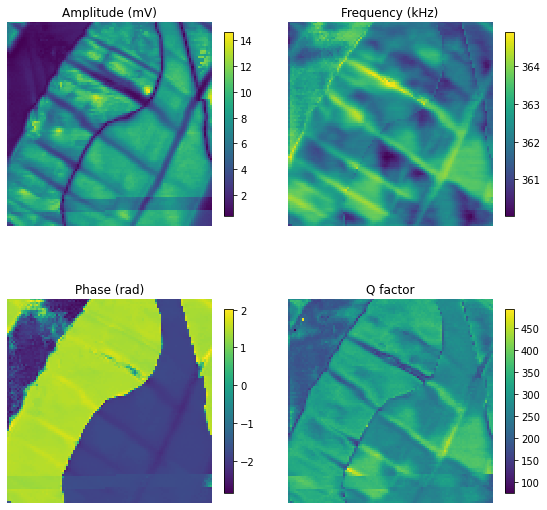

In [4]:
rz = 100  #set the size of dataset
amp = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Guess']['Amplitude [V]'].reshape(rz,rz, 40)
pha = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Guess']['Phase [rad]'].reshape(rz,rz, 40)
fre = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Guess']['Frequency [Hz]'].reshape(rz,rz, 40)
q = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Guess']['Quality Factor'].reshape(rz,rz, 40)
r2 = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess']['R2 Criterion'].reshape(rz,rz, 40)
pola = amp*np.cos(pha)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
#fig.suptitle ('c2r1_2kcycled/BEPFM_0004.h5')
# Make 4 subplots:
cm = 'viridis'
shrink = 0.8
s = 0

im1 = axs[0, 0].imshow(amp.mean(2)*10e3, interpolation='nearest', cmap=cm)
fig.colorbar(im1, ax=axs[0, 0], shrink = shrink)
#axs[0, 0].set_title("Amplitude (µV)")
axs[0, 0].set_title("Amplitude (mV)")
axs[0, 0].axis('off')

im2 = axs[1, 0].imshow(pha.mean(2), interpolation='nearest', cmap=cm)
fig.colorbar(im2, ax=axs[1, 0], shrink = shrink)
axs[1, 0].set_title("Phase (rad)")
axs[1, 0].axis('off')

im3 = axs[0, 1].imshow(fre.mean(2)/1000, interpolation='nearest', cmap=cm)
fig.colorbar(im3, ax=axs[0, 1], shrink = shrink)
axs[0, 1].set_title("Frequency (kHz)")
axs[0, 1].axis('off')

im4 = axs[1, 1].imshow(q.mean(2), interpolation='nearest', cmap=cm)
fig.colorbar(im4, ax=axs[1, 1], shrink = shrink)
axs[1, 1].set_title("Q factor")
axs[1, 1].axis('off')

plt.show()

plot spectra

In [5]:
sho_mat = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit']
pos_inds = h5['Measurement_000/Channel_000/Position_Indices']
pos_dim_sizes = [np.max(pos_inds[:,0])+1, np.max(pos_inds[:,1]+1)]
sho_mat_ndim = sho_mat[:].reshape(pos_dim_sizes[0], pos_dim_sizes[1], -1)
amp_mat_ndim = sho_mat_ndim['Amplitude [V]']
spec_val = h5['Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Spectroscopic_Values']

amp_norm = (amp_mat_ndim-amp_mat_ndim.min())/(amp_mat_ndim.max()-amp_mat_ndim.min())

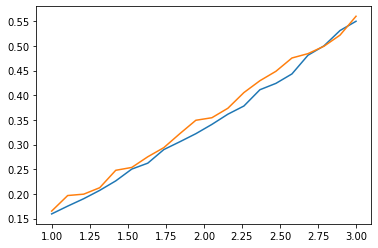

In [6]:
#separate forward and reverse spectra
Vac_f = spec_val[0][:20]
Vac_r = spec_val[0][20:]
amp_f = amp_norm[:,:,:20]
amp_r = amp_norm[:,:,20:]

plt.plot(Vac_f, amp_f[55,65,])
plt.plot(Vac_r, amp_r[55,65,])

# Fit the spectra

In [7]:
#define fit function

def func_ (x, a, b, c):
    return a*x*x*x + b*x*x + c*x

s=100
popt_qua = np.zeros((s,s,2,3))   #initialize an array to save fit results

In [8]:
#fit, and save results
from scipy.optimize import curve_fit
for i in range (s):
    for j in range (s):
        yf = amp_f[i, j, ]
        yr = amp_r[i, j, ]
        popt1, _ = curve_fit(func_, Vac_f, yf)
        popt2, _ = curve_fit(func_, Vac_r, yr)
        popt_qua[i, j, 0,] = popt1
        popt_qua[i, j, 1,] = popt2

In [ ]:
#fitted spectra
ffi = np.copy (amp_f)
fri = np.copy (amp_r)
for i in range (s):
    for j in range (s):
        ffi[i,j,] = func_(Vac_f, *popt_qua[i, j, 0,])
        fri[i,j,] = func_(Vac_f, *popt_qua[i, j, 0,])

In [ ]:
#compare fit spectra and raw spectra
k1 = 10; k2 = 50  #select the location to look
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
fig.subplots_adjust(wspace=0.3, hspace = 0.3)
ax1.plot(Vac_f, amp_f[k1, k2, ], label = 'raw forward')
ax1.plot(Vac_f, func_(Vac_f, *popt_qua[k1, k2, 0,]), label = 'fitting')
ax1.set_xlabel('AC_amp (V)')
ax1.set_ylabel('Amplitude')
ax2.plot(Vac_r, amp_r[k1, k2, ], label = 'raw reverse')
ax2.plot(Vac_r, func_(Vac_r, *popt_qua[k1, k2, 1,]), label = 'fitting')
ax2.set_xlabel('AC_amp (V)')
ax2.set_ylabel('Amplitude')

ax1.legend()
ax2.legend()
plt.show()

### Plot 3 coefficient from fitting as images

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi = 100)
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.95, top=0.99, wspace=0.15)

# Make 3 subplots:
cm = 'viridis'
shrink = 0.7

im1 = axs[0].imshow(popt_qua[:,:,0,0], interpolation='nearest', cmap=cm, origin = 'lower')
fig.colorbar(im1, ax=axs[0], shrink = shrink, label = "coefficient $a$")
axs[0].axis('off')

im2 = axs[1].imshow(popt_qua[:,:,0,1], interpolation='nearest', cmap=cm, origin = 'lower')
fig.colorbar(im2, ax=axs[1], shrink = shrink, label = "coefficient $b$")
axs[1].axis('off')

im3 = axs[2].imshow(popt_qua[:,:,0,2], interpolation='nearest', cmap=cm, origin = 'lower')
fig.colorbar(im3, ax=axs[2], shrink = shrink, label = "coefficient $c$")
axs[2].axis('off')

plt.show()

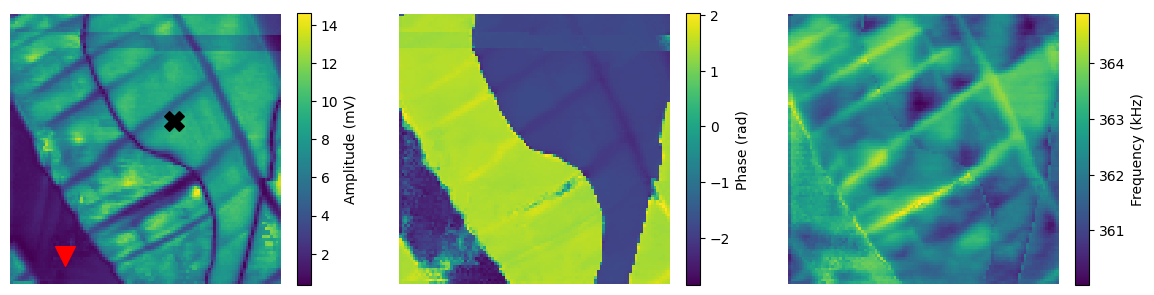

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi = 100)
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.95, top=0.99, wspace=0.15)

# Make 3 subplots:
cm = 'viridis'
shrink = 0.7
s = 0

#select two locations to check their spectra
s1 = 20; s2 = 10
s11 = 60; s22 = 60

im1 = axs[0].imshow(amp.mean(2)*10e3, interpolation='nearest', cmap=cm, origin = 'lower')
axs[0].scatter(s11, s22, c = 'black', marker = 'X', s = 200 )
axs[0].scatter(s1, s2, c = 'r', marker = 'v', s = 200 )

fig.colorbar(im1, ax=axs[0], shrink = shrink, label = "Amplitude (mV)")
axs[0].axis('off')

im2 = axs[1].imshow(pha.mean(2), interpolation='nearest', cmap=cm, origin = 'lower')
fig.colorbar(im2, ax=axs[1], shrink = shrink, label = "Phase (rad)")
axs[1].axis('off')

im3 = axs[2].imshow(fre.mean(2)/1000, interpolation='nearest', cmap=cm, origin = 'lower')
fig.colorbar(im3, ax=axs[2], shrink = shrink, label = "Frequency (kHz)")
axs[2].axis('off')


plt.show()

In [ ]:
# plot spectra at two selected locations
fig, axs = plt.subplots(figsize=(4, 5), dpi = 300)
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.95, top=0.99, wspace=0.1)

cm = 'viridis'
shrink = 0.7
s = 0

axs.scatter(Vac_f, amp_f[s11, s22, ], marker = 'X', 
            color = "black",label = 'Location 1', )
axs.scatter(Vac_f, amp_f[s1, s2, ], marker = 'v', 
            color = 'r', label = 'Location 2', )
axs.plot(Vac_f, func_(Vac_f, *popt_qua[s11, s22, 0,]), c = 'black', 
         label = 'Fit 2: $a=%5.3f, b=%5.3f, c=%5.3f$' % tuple(popt_qua[s11, s22, 0]))
axs.plot(Vac_f, func_(Vac_f, *popt_qua[s1, s2, 0,]), c = 'r', 
         label = 'Fit 1: $a=%5.3f, b=%5.3f, c=%5.3f$' % tuple(popt_qua[s1, s2, 0]))

axs.set_xlabel('V$_a$$_c$ (V)')
axs.set_ylabel('Normalized Amplitude')
axs.legend(frameon = False)

plt.show()

## **Perform DKL analysis**

### Prepare DKL training data

In [14]:
#normalize maplitude
norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
amp_ = norm_(amp[:,:,0]) #amp
amp_f = norm_(amp_f)
amp_r = norm_(amp_r)

extract sub images as features_all

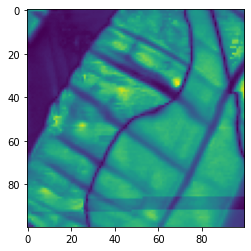

In [15]:
amp_ = amp.mean(2)
amp_ = (amp_-amp_.min())/(amp_.max()-amp_.min())
coordinates = utils.get_coord_grid(amp_, 1)

# extract subimage for each point on a grid
ws = 30
features_all, coords, _ = utils.extract_subimages(amp_, coordinates, ws)
features_all = features_all[:,:,:,0]

plt.imshow(features_all[20])
plt.imshow(amp_)

In [16]:
# coordnates as indices
pix = 71

indices_all = coords
indices = coords.reshape(pix,pix,2)
indices.shape

(71, 71, 2)

Prepare data for training:

In [17]:
A_ = np.zeros(pix*pix)
B_ = np.zeros(pix*pix)
C_ = np.zeros(pix*pix)

for i in range (pix*pix):
    A_ [i] = popt_qua[int(indices_all[i,0]), int(indices_all[i,1]),0,0] 
    B_ [i] = popt_qua[int(indices_all[i,0]), int(indices_all[i,1]),0,1]
    C_ [i] = popt_qua[int(indices_all[i,0]), int(indices_all[i,1]),0,2]

In [18]:
# Flatten image data
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
t = C_  #set y_train as A, B, or C    
y = (t-t.min())/(t.max()-t.min())

X.shape, y.shape

((5041, 900), (5041,))

DKL training

In [19]:
data_dim = X.shape[-1]

dklgp = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
dklgp.fit(X, y, training_cycles=200)  

Epoch 1/200 ... Training loss: 0.7452
Epoch 10/200 ... Training loss: 0.7109
Epoch 20/200 ... Training loss: 0.6736
Epoch 30/200 ... Training loss: 0.6367
Epoch 40/200 ... Training loss: 0.5973
Epoch 50/200 ... Training loss: 0.5563
Epoch 60/200 ... Training loss: 0.5152
Epoch 70/200 ... Training loss: 0.4734
Epoch 80/200 ... Training loss: 0.4302
Epoch 90/200 ... Training loss: 0.3863
Epoch 100/200 ... Training loss: 0.3413
Epoch 110/200 ... Training loss: 0.2954
Epoch 120/200 ... Training loss: 0.2487
Epoch 130/200 ... Training loss: 0.2006
Epoch 140/200 ... Training loss: 0.1521
Epoch 150/200 ... Training loss: 0.1035
Epoch 160/200 ... Training loss: 0.0544
Epoch 170/200 ... Training loss: 0.0041
Epoch 180/200 ... Training loss: -0.0465
Epoch 190/200 ... Training loss: -0.0975
Epoch 200/200 ... Training loss: -0.1457


DKL prediction

In [ ]:
mean, var = dklgp.predict(X, batch_size=len(X))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

cm = 'viridis'
shrink = 0.7

im1 = ax1.imshow(y.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
fig.colorbar(im1, ax=ax1, shrink = shrink)
ax1.set_title("Ground truth")
ax1.axis('off')

im2 = ax2.imshow(mean.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
fig.colorbar(im2, ax=ax2, shrink = shrink)
ax2.set_title("DKL predicted")
ax2.axis('off')

im3 = ax3.imshow(var.reshape(pix,pix), interpolation='nearest', origin = "lower", cmap=cm)
fig.colorbar(im3, ax=ax3, shrink = shrink)
ax3.set_title("DKL uncertainty")
ax3.axis('off')

Latent variables

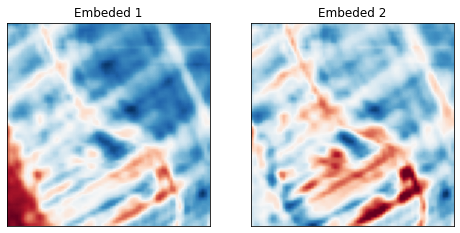

In [21]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(embeded[:,0].reshape(pix, pix), origin = "lower", cmap='RdBu')
ax1.set_title("Embeded 1")
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.tick_params(axis='both', which='both', length=0)

ax2.imshow(embeded[:,1].reshape(pix, pix), origin = "lower", cmap='RdBu')
ax2.set_title("Embeded 2")
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(axis='both', which='both', length=0)